In [1]:
import gzip
import shutil
import pandas as pd
import numpy as np
from statsmodels.regression import linear_model
import matplotlib.pyplot as plt

In [2]:
contract = 'ETH-BTC_2018' #Here to modify the pair we want to research. 
path1 = 'C:/Users/Krist/OneDrive/desktop/quant strategies/hw3/book_narrow_'
path2 = 'C:/Users/Krist/OneDrive/desktop/quant strategies/hw3/trades_narrow_'
path3 = '.delim.gz'
path4 = '.txt'
path_in_book = path1+contract+path3
path_in_trades = path2+contract+path3
path_out_book = path1+contract+path4
path_out_trades = path2+contract+path4

In [3]:
#decompress the files
with gzip.open(path_in_book, 'rb') as f_in:
    with open(path_out_book, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
with gzip.open(path_in_trades, 'rb') as f_in:
    with open(path_out_trades, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [4]:
#read data and modify
book = pd.read_csv(path_out_book,sep = "|")
trades = pd.read_csv(path_out_trades,sep = "|")

book = book.rename(columns = {'Mid ':'Mid'})

In [5]:
#train test split
train_period = 0.2
trade_stamp = list(trades['timestamp_utc_nanoseconds'].drop_duplicates())
trade_stamp.sort()

train = [t for t in trade_stamp if t < trade_stamp[int(len(trade_stamp)*train_period)]]
test = [t for t in trade_stamp if t >= trade_stamp[int(len(trade_stamp)*train_period)]]

In [6]:
#parameter
tau = 5*60*10**9
T = 10*60*10**9

In [7]:
#get flow and return on the training dataset
book = book.sort_values(by = ['received_utc_nanoseconds'])
flow = []
forward = []
for t in train:
    trades_seg = trades.loc[(trades['timestamp_utc_nanoseconds']>=t-tau) & (trades['timestamp_utc_nanoseconds']<t)]
    flow_seg = (trades_seg['PriceMillionths']*trades_seg['Side']*trades_seg['SizeBillionths']).sum()
    flow.append(flow_seg)
    book_seg = book.loc[(book['received_utc_nanoseconds']>=t) & (book['received_utc_nanoseconds']<t+T)]
    if len(book_seg) == 0:
        forward.append(np.nan)
    else:
        forward_seg = book_seg.loc[book_seg.index[-1],'Mid']/book_seg.loc[book_seg.index[0],'Mid']-1
        forward.append(forward_seg)

In [8]:
#regression
reg_data_set = pd.DataFrame({'flow':flow, 'forward':forward})
reg_data_set = reg_data_set.dropna()
regression = linear_model.OLS(reg_data_set['forward'],reg_data_set['flow'])
result = regression.fit()
print(result.params)
print(result.tvalues)
beta = result.params[0]

flow    5.365325e-20
dtype: float64
flow    13.604891
dtype: float64


In [9]:
#get flow and return on the testing dataset
flow_test = []
forward_test = []
for t in test:
    trades_seg = trades.loc[(trades['timestamp_utc_nanoseconds']>=t-tau) & (trades['timestamp_utc_nanoseconds']<t)]
    flow_seg = (trades_seg['PriceMillionths']*trades_seg['Side']*trades_seg['SizeBillionths']).sum()
    flow_test.append(flow_seg)
    book_seg = book.loc[(book['received_utc_nanoseconds']>=t) & (book['received_utc_nanoseconds']<t+T)]
    if len(book_seg) == 0:
        forward_test.append(np.nan)
    else:
        forward_seg = book_seg.loc[book_seg.index[-1],'Mid']/book_seg.loc[book_seg.index[0],'Mid']-1
        forward_test.append(forward_seg)
forward_estimate = [f*beta for f in flow_test]

In [10]:
#calculate the prediction accuracy
tp = [i for i in range(len(forward_estimate)) if (forward_estimate[i] >= 0) & (forward_test[i] >= 0)]
tn = [i for i in range(len(forward_estimate)) if (forward_estimate[i] < 0) & (forward_test[i] < 0)]
fp = [i for i in range(len(forward_estimate)) if (forward_estimate[i] >= 0) & (forward_test[i] < 0)]
fn = [i for i in range(len(forward_estimate)) if (forward_estimate[i] < 0) & (forward_test[i] >= 0)]
print(len(tp))
print(len(tn))
print(len(fp))
print(len(fn))

4688
1463
2592
3612


0.00010751337155842282
-3.404067068020925e-05
(0.00011, -0.037224549075476766)
(0.00012000000000000002, -0.03020647475747498)
(0.00013000000000000002, -0.02980462497181089)
(0.00014000000000000001, -0.023567954664974324)
(0.00015000000000000001, -0.02070880020088324)
(0.00016, -0.023227062023899177)
(0.00017, -0.021518014699130287)
(0.00018, -0.01733500898254503)
(0.00019, -0.023626420286876147)


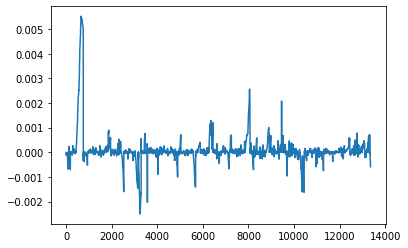

In [11]:
#how to choose j, the process to evaluate the best j
plt.plot(forward_estimate)
print(np.percentile(forward_estimate,80))
print(np.percentile(forward_estimate,20))
jlist = [0.00001*i for i in range(11,20)]#[0.0001*i for i in range(1,10)]#[0.001*i for i in range(1,6)]
for j in jlist:
    opportunity = [i for i in range(len(forward_estimate)) if abs(forward_estimate[i])>j]
    side = [0]*len(opportunity)
    k = 0
    for i in opportunity:
        if forward_estimate[i] > 0:
            side[k] = 1
        else:
            side[k] = -1
        k += 1
    gross_ret = [(1+forward_test[opportunity[i]]*side[i]) for i in range(len(opportunity))]
    ret = [(forward_test[opportunity[i]]*side[i]) for i in range(len(opportunity))]
    sharpe = np.nanmean(ret)/np.nanstd(ret)
    print((j,sharpe))

In [12]:
#get return distributions and stats with one fixed j
j = 0.00018
opportunity = [i for i in range(len(forward_estimate)) if abs(forward_estimate[i])>j]
side = [0]*len(opportunity)
k = 0
for i in opportunity:
    if forward_estimate[i] > 0:
        side[k] = 1
    else:
        side[k] = -1
    k += 1
gross_ret = [(1+forward_test[opportunity[i]]*side[i]) for i in range(len(opportunity))]
ret = [(forward_test[opportunity[i]]*side[i]) for i in range(len(opportunity))]
sharpe = np.nanmean(ret)/np.nanstd(ret)
print((j,sharpe))
print((pd.Series(ret)).describe())
print((pd.Series(ret)).skew())
print((pd.Series(ret)).kurtosis())

(0.00018, -0.01733500898254503)
count    2753.000000
mean       -0.000035
std         0.002002
min        -0.007697
25%        -0.001185
50%         0.000000
75%         0.000513
max         0.009362
dtype: float64
1.090447004408795
2.4264331893434115
